In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
from tqdm import tqdm
import math
import seaborn as sns

from scipy.stats import norm
import scipy.stats as st

import warnings

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params); np.random.seed(0)
style.use('tableau-colorblind10')

#%matplotlib inline
tqdm.pandas()
warnings.filterwarnings('ignore')

# import plotly
# import plotly.figure_factory as ff
# import plotly.graph_objs as go 
# import plotly.express as px
# import plotly.offline as pyo
# from plotly.subplots import make_subplots
#pyo.init_notebook_mode()

Note that the `Load & Pre-process Datasets` are the replicate of `main.ipynb`.

# Load & Pre-process Datasets

This procedures are the replicates in the pre-processing procedures in `main.ipynb`.

1. Load `food` dataset which contains all 35.9M pairs of food pantry info and its BGs within 25 miles. We have created this dataset from the jupyter file `prepare_data_statistics.ipynb`. 
- There are 34,475 food pantries and banks (FPs) in the dataset. 

In [3]:
food = pd.read_pickle('../data/food_bg20_adi_st.pkl')

In [4]:
food.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35940827 entries, 0 to 35940826
Data columns (total 12 columns):
 #   Column         Dtype  
---  ------         -----  
 0   address        object 
 1   ad_lat         float64
 2   ad_lon         float64
 3   ad_bg_fips     object 
 4   bg_fips        object 
 5   bg_lat         float64
 6   bg_lon         float64
 7   distance_mi    float64
 8   ADI_NATRANK    int64  
 9   ADI_STATERNK   int64  
 10  bg_state       object 
 11  address_state  object 
dtypes: float64(5), int64(2), object(5)
memory usage: 3.2+ GB


In [5]:
food.address.nunique()

34475

2. Load `bg` dataset (the original ADI dataset from UW Madison's Neighborhood Atlas). This dataset will be mainly used for filtering BGs that do have FPs within 25 miles or not. 

- `bg_cont`: BGs in the continental U.S -> a total of 239,780 BGs in 50 states and the DC.

In [6]:
bg = pd.read_csv('../data/US_2020_ADI_Census Block Group_v3.2.csv',
                dtype={'FIPS':str, 'ADI_NATRANK':str, 'ADI_STATERNK':str})
bg = bg[['FIPS', 'ADI_NATRANK', 'ADI_STATERNK']]
bg = bg.rename(columns={'FIPS':'bg_fips'})

In [7]:
bg_cont = bg.loc[(~bg.bg_fips.str.startswith('72')) 
             & (~bg.bg_fips.str.startswith('78'))
            & (~bg.bg_fips.str.startswith('69'))
            & (~bg.bg_fips.str.startswith('66'))
            & (~bg.bg_fips.str.startswith('60'))]

In [8]:
bg_cont.bg_fips.nunique()

239780

3. Find and merge the state/county info for each BG

- `find_sate_fips` retrieves the corresponding state information based on the first two digits of each BG's FIPS. 
- `us-state-fips.csv` contains all FIPS code of the 50 states and DC in the continental U.S.
- Note that the first two and five digits of each BG's FIPS indicate the BG's state and county, respectively. 

In [9]:
def find_state_fips(bg, state_data):
    
    st_fips = bg[:2]
    for i in range(len(state_data)):
        if state_data['st_fips'][i] == st_fips:            
            return state_data['st_abb'][i]

In [10]:
state_fips = pd.read_csv('../data/us-state-fips.csv',
                        dtype = {'stname':str, ' st':str, ' stusps':str})
state_fips = state_fips.rename(columns={'stname':'STATE', ' st':'st_fips', ' stusps':'st_abb'})
state_fips.st_abb = state_fips.st_abb.str.strip()
state_fips.st_fips = state_fips.st_fips.str.strip()

In [11]:
bg_cont['bg_state'] = bg_cont.progress_apply(lambda x:find_state_fips(x.bg_fips, state_fips), axis=1)
bg_cont['bg_county']  = bg_cont.progress_apply(lambda x:x.bg_fips[0:5], axis=1)

100%|██████████| 239780/239780 [00:00<00:00, 268763.76it/s]


4. Find each BG's rural status (based on RUCC 2013 Codes)
- `county_rurality`: the entire county-level dataset of RUCC 2013 codes from USDA ERS, where BGs in counties tagged with all subcategories within 'Metro' are considered as urban and all within 'Nonmetro' as rural. 

In [12]:
county_rurality = pd.read_csv('../data/ruralurbancodes2013.csv', 
                          dtype = {'FIPS':str})

county_rurality['RUCC_2013'] = county_rurality['RUCC_2013'].astype(str)
county_rurality.Description = county_rurality.Description.str.strip()

def decide_urban_degree(text):
    
    if text in ['Metro - Counties in metro areas of 250,000 to 1 million population',
       'Metro - Counties in metro areas of fewer than 250,000 population', 
               'Metro - Counties in metro areas of 1 million population or more']:
        
        return 'Metro'
    
    elif text in ['Nonmetro - Urban population of 20,000 or more, adjacent to a metro area', 
                  'Nonmetro - Urban population of 20,000 or more, not adjacent to a metro area']:
        return 'Nonmetro'
    
    elif text in ['Nonmetro - Urban population of 2,500 to 19,999, not adjacent to a metro area',
                  'Nonmetro - Urban population of 2,500 to 19,999, adjacent to a metro area']:
        return 'Nonmetro'
    
    elif text in ['Nonmetro - Completely rural or less than 2,500 urban population, not adjacent to a metro area',
                  'Nonmetro - Completely rural or less than 2,500 urban population, adjacent to a metro area']:
        return 'Nonmetro'
    else:
        return 'N/A'


county_rurality['status'] = county_rurality.apply(lambda x:decide_urban_degree(x.Description), axis=1)
county_rurality = county_rurality.rename(columns={'FIPS':'bg_county'})
county_rurality 

,bg_county,State,County_Name,Population_2010,RUCC_2013,Description,status
0,01001,AL,Autauga County,"54,571",2.0,"Metro - Counties in metro areas of 250,000 to ...",Metro
1,01003,AL,Baldwin County,"182,265",3.0,Metro - Counties in metro areas of fewer than ...,Metro
2,01005,AL,Barbour County,"27,457",6.0,"Nonmetro - Urban population of 2,500 to 19,999...",Nonmetro
3,01007,AL,Bibb County,"22,915",1.0,Metro - Counties in metro areas of 1 million p...,Metro
4,01009,AL,Blount County,"57,322",1.0,Metro - Counties in metro areas of 1 million p...,Metro
...,...,...,...,...,...,...,...
3229,72151,PR,Yabucoa Municipio,"37,941",1.0,Metro - Counties in metro areas of 1 million p...,Metro
3230,72153,PR,Yauco Municipio,"42,043",2.0,"Metro - Counties in metro areas of 250,000 to ...",Metro
3231,78010,VI,St. Croix Island,"50,601",5.0,"Nonmetro - Urban population of 20,000 or more,...",Nonmetro
3232,78020,VI,St. John Island,"4,170",7.0,"Nonmetro - Urban population of 2,500 to 19,999...",Nonmetro


5. Merge `bg_cont` with the `county_rurality` information, resulting in a dataset of all block groups' FIPS code, their ADI, state/county, and urban/rural status. 

In [13]:
bg_cont = bg_cont.merge(county_rurality[['bg_county', 'status']].drop_duplicates(subset=['bg_county']), how='left', on='bg_county')

In [14]:
bg_cont

,bg_fips,ADI_NATRANK,ADI_STATERNK,bg_state,bg_county,status
0,010010201001,73,5,AL,01001,Metro
1,010010201002,62,3,AL,01001,Metro
2,010010202001,83,7,AL,01001,Metro
3,010010202002,87,7,AL,01001,Metro
4,010010203001,73,5,AL,01001,Metro
...,...,...,...,...,...,...
239775,560459511001,65,8,WY,56045,Nonmetro
239776,560459511002,49,6,WY,56045,Nonmetro
239777,560459513001,85,10,WY,56045,Nonmetro
239778,560459513002,70,9,WY,56045,Nonmetro


6. (Optional) Split all 239,780 BGs in the continental U.S. into two distinct groups: 

(1) `bg_yes_pantry` (232,735 BGs that do have at least one food pantry (FP) ≤ 25 miles), 

(2) `bg_no_pantry` (7,045 BGs that do not have any FPs ≤ 25 miles). Note that only 1,145 BGs out of 7,045 BGs that do not have FPs ≤ 25 miles show valid (e.g., non-missing and numeric) national ADI percentile values. 

In [15]:
bg_with_fp = food.bg_fips.unique() # All BGs in our dataset that are identified as having at least a FP < 25 miles 

In [16]:
bg_yes_pantry = bg_cont.loc[(bg_cont.bg_fips.isin(bg_with_fp))
            & (bg_cont['ADI_NATRANK'].isna()==False)
            & (bg_cont['ADI_NATRANK'].str.isnumeric())].reset_index(drop=True)

bg_yes_pantry['ADI_NATRANK'] = bg_yes_pantry['ADI_NATRANK'].astype(int)

In [17]:
bg_no_pantry = bg_cont.loc[(~bg_cont.bg_fips.isin(bg_with_fp))
            & (bg_cont['ADI_NATRANK'].isna()==False)
            & (bg_cont['ADI_NATRANK'].str.isnumeric())].reset_index(drop=True)

bg_no_pantry['ADI_NATRANK'] = bg_no_pantry['ADI_NATRANK'].astype(int)

Now, it's time to pre-process the accessibility dataset. 

7. Pre-process the accessibility dataset

`bg_access`: the dataset that we created from `compute_travel_time.ipynb` file, which consists of all information about each BG and its nearest FP, along with distance/travel time between them, ADI and state info. 

In [18]:
bg_access = pd.read_csv('../data/bg_transit_adi.csv', dtype={'bg_fips':str})

In [19]:
bg_access = bg_access[['bg_fips', 'address', 'distance_mi', 'ADI_NATRANK', 'ADI_STATERNK', 
                        'bg_state', 'address_state' ,'transit_time', 'walking_time']]

In [20]:
bg_access.head()

,bg_fips,address,distance_mi,ADI_NATRANK,ADI_STATERNK,bg_state,address_state,transit_time,walking_time
0,010010201001,"203 N Court St, Prattville, AL 36067",0.835864,73,5,AL,AL,20.08,20.08
1,010010201002,"203 N Court St, Prattville, AL 36067",1.684913,62,3,AL,AL,37.30,37.30
2,010010202001,"203 N Court St, Prattville, AL 36067",1.065305,83,7,AL,AL,20.33,20.33
3,010010202002,"203 N Court St, Prattville, AL 36067",0.327409,87,7,AL,AL,8.40,8.40
4,010010203001,"203 N Court St, Prattville, AL 36067",1.367486,73,5,AL,AL,42.63,42.63


8. Merge with `bg_county` and `status` (rural or urban) information for each BG

In [21]:
bg_access['bg_county'] = bg_access.progress_apply(lambda x:x.bg_fips[:5], axis=1)

100%|██████████| 232735/232735 [00:00<00:00, 265187.88it/s]


In [22]:
bg_access = bg_access.merge(county_rurality[['bg_county', 'status']].drop_duplicates(subset=['bg_county']), how='left', on='bg_county')

Because `bg_access` contains only 232,735 BGs that do have FPs ≤ 25 miles so that we can compute travel time, we also include the other BGs in `bg_no_pantry` that do not have FPs ≤ 25 miles to update `bg_access`.

In [23]:
bg_access = pd.concat([bg_access, bg_cont.loc[(~bg_cont.bg_fips.isin(bg_with_fp))]])

In [24]:
bg_access

,bg_fips,address,distance_mi,ADI_NATRANK,ADI_STATERNK,bg_state,address_state,transit_time,walking_time,bg_county,status
0,010010201001,"203 N Court St, Prattville, AL 36067",0.835864,73,5,AL,AL,20.08,20.08,01001,Metro
1,010010201002,"203 N Court St, Prattville, AL 36067",1.684913,62,3,AL,AL,37.30,37.30,01001,Metro
2,010010202001,"203 N Court St, Prattville, AL 36067",1.065305,83,7,AL,AL,20.33,20.33,01001,Metro
3,010010202002,"203 N Court St, Prattville, AL 36067",0.327409,87,7,AL,AL,8.40,8.40,01001,Metro
4,010010203001,"203 N Court St, Prattville, AL 36067",1.367486,73,5,AL,AL,42.63,42.63,01001,Metro
...,...,...,...,...,...,...,...,...,...,...,...
239768,560430002003,NaN,NaN,47,5,WY,NaN,NaN,NaN,56043,Nonmetro
239776,560459511002,NaN,NaN,49,6,WY,NaN,NaN,NaN,56045,Nonmetro
239777,560459513001,NaN,NaN,85,10,WY,NaN,NaN,NaN,56045,Nonmetro
239778,560459513002,NaN,NaN,70,9,WY,NaN,NaN,NaN,56045,Nonmetro


Based on our definition of accessibility, we compute shorter travel time to measure accessibility, by the least travel time by transit or walking. This is stored in the `access` column. 

In [25]:
def shorter_travel(transit, walk):
    travel = 0
    if np.isnan(transit) == False:
        if np.isnan(walk) == False:
            if transit >= walk: # transit 0 walk 0
                travel = walk
            else:
                travel = transit
        else: # transit 0 walk x
            travel = transit
    else: #transit x
        if np.isnan(walk) == False: # transit x walk 0
            travel = walk
        else:
            travel = None # transit x walk x

    return travel

In [26]:
bg_access['access'] = bg_access.progress_apply(lambda x:shorter_travel(x.transit_time, x.walking_time), axis=1)

100%|██████████| 239780/239780 [00:01<00:00, 121991.91it/s]


In [27]:
def isnumber(x): # convert all ADI to its numeric format
    try:
        d = int(x)
        return d
    except:
        return None


bg_access['ADI_NATRANK'] = bg_access.progress_apply(lambda x:isnumber(x.ADI_NATRANK), axis=1)

100%|██████████| 239780/239780 [00:00<00:00, 251069.84it/s]


Then, we have all 239,780 BGs in the continental U.S., along with their accessibility information!

In [28]:
easy_access = pd.concat([bg_access.loc[(bg_access.transit_time.isna()) & (bg_access.walking_time <= 20)], 
                        bg_access.loc[(bg_access.transit_time <= 40) & (bg_access.walking_time.isna())], 
                        bg_access.loc[(bg_access.transit_time <= 40) & (bg_access.walking_time <= 20)], 
                        bg_access.loc[(bg_access.transit_time <= 40) & (bg_access.walking_time > 20)], 
                        bg_access.loc[(bg_access.transit_time > 40) & (bg_access.walking_time <= 20)]], ignore_index=True)

easy_access['access'] = easy_access.progress_apply(lambda x:shorter_travel(x.transit_time, x.walking_time), axis=1)

100%|██████████| 125835/125835 [00:01<00:00, 122038.75it/s]


In [29]:
diff_access = pd.concat([bg_access.loc[(bg_access.transit_time.isna()) & (bg_access.walking_time > 20)], 
                        bg_access.loc[(bg_access.transit_time > 40) & (bg_access.walking_time.isna())], 
                        bg_access.loc[(bg_access.transit_time > 40) & (bg_access.walking_time > 20)]], ignore_index=True)

diff_access['access'] = diff_access.progress_apply(lambda x:shorter_travel(x.transit_time, x.walking_time), axis=1)

100%|██████████| 106502/106502 [00:00<00:00, 121962.72it/s]


In [30]:
no_access = bg_access.loc[(bg_access.transit_time.isna()) & (bg_access.walking_time.isna())]
no_access['access'] = no_access.progress_apply(lambda x:shorter_travel(x.transit_time, x.walking_time), axis=1)

100%|██████████| 7443/7443 [00:00<00:00, 115320.58it/s]


-------------------------------------------------------------------------------------------

# Supplementary Table 1

- Number of food pantries and banks (FPs) by states (including the District of Columbia (DC))

In [31]:
num_fps_state = pd.DataFrame(food.groupby('address').first().address_state.value_counts()).sort_index()

- Number of BGs per state

In [32]:
num_bg_state = pd.DataFrame(bg_access.bg_state.value_counts()).sort_index()

- Number of easy/difficult/no access BGs per state

In [33]:
num_easy_state = pd.DataFrame(easy_access.bg_state.value_counts()).sort_index()
num_diff_state = pd.DataFrame(diff_access.bg_state.value_counts()).sort_index()
num_no_state = pd.DataFrame(no_access.bg_state.value_counts()).sort_index()

In [34]:
supp_t_1 = pd.concat([num_fps_state, num_bg_state, num_easy_state, num_diff_state, num_no_state], axis=1)
supp_t_1.columns = ['num_fp', 'num_bg', 'num_easy_bg', 'num_diff_bg', 'num_no_bg']

In [35]:
supp_t_1

,num_fp,num_bg,num_easy_bg,num_diff_bg,num_no_bg
AK,146,504,215,180,109
AL,843,3925,1345,2489,91
AR,970,2294,886,1370,38
AZ,660,4773,2503,2044,226
CA,1583,25607,15820,9241,546
CO,557,4058,2315,1607,136
CT,554,2716,1676,983,57
DC,41,571,509,23,39
DE,85,706,366,319,21
FL,1504,13388,7123,5936,329


# Supplementary Table 2

Refer to `regression.ipynb` file. 

# Supplementary Figure 1

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 [Text(0, 0, '1.0'),
  Text(1, 0, '2.0'),
  Text(2, 0, '3.0'),
  Text(3, 0, '4.0'),
  Text(4, 0, '5.0'),
  Text(5, 0, '6.0'),
  Text(6, 0, '7.0'),
  Text(7, 0, '8.0'),
  Text(8, 0, '9.0'),
  Text(9, 0, '10.0'),
  Text(10, 0, '11.0'),
  Text(11, 0, '12.0'),
  Text(12, 0, '13.0'),
  Text(13, 0, '14.0'),
  Text(14, 0, '15.0'),
  Text(15, 0, '16.0'),
  Text(16, 0, '17.0'),
  Text(17, 0, '18.0'),
  Text(18, 0, '19.0'),
  Text(19, 0, '20.0'),
  Text(20, 0, '21.0'),
  Text(21, 0, '22.0'),
  Text(22, 0, '23.0'),
  Text(23, 0, '24.0'),
  Text(24, 0, '25.0')])

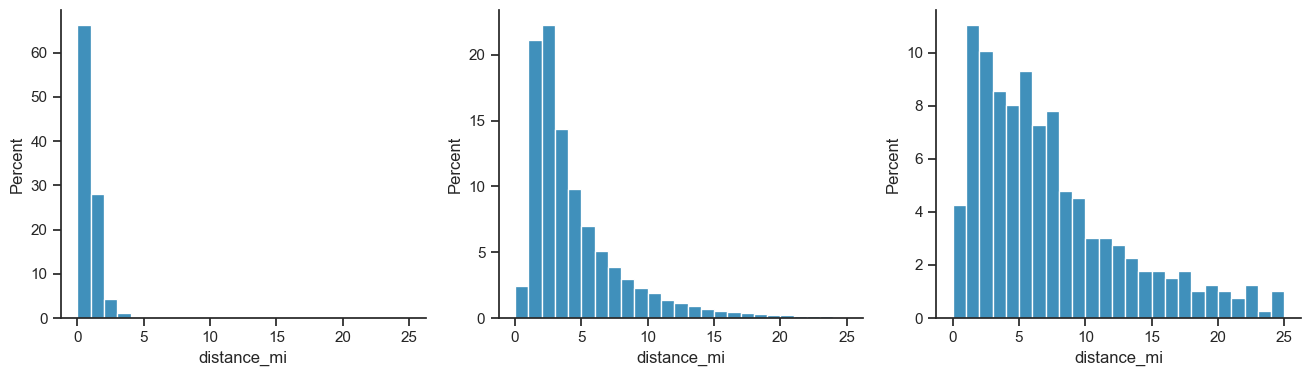

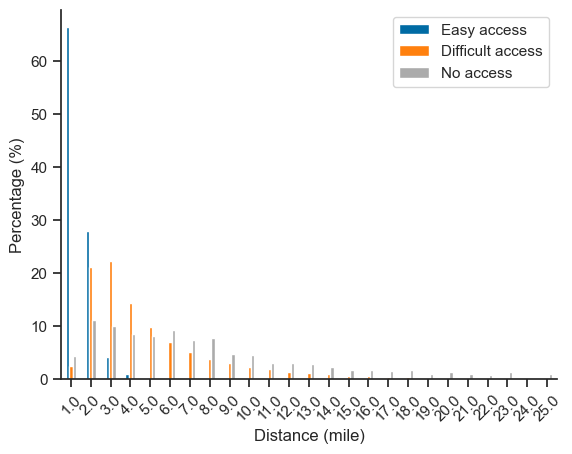

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(16,4))
fig.subplots_adjust(hspace = 0.5)
#fig.suptitle('Distribution of Geographic Accessibility from BGs to each of their nearest FPs')

# distance
e = sns.histplot(ax=axes[0], data=easy_access.distance_mi, stat='percent', 
            bins=np.arange(0, 25.1, 1))
#axes[0].set(xlabel='distance (mi)', ylabel='Percentage (%)')
#axes[0].set_title('Easy access by transit or walk', pad=5)

d = sns.histplot(ax=axes[1], data=diff_access.distance_mi, stat='percent', 
            bins=np.arange(0, 25.1, 1))
#axes[1].set(xlabel='distance (mi)', ylabel='Percentage (%)')
#axes[1].set_title('Difficult access by transit or walk')


n = sns.histplot(ax=axes[2], data=no_access.distance_mi, stat='percent', 
            bins=np.arange(0, 25.1, 1))
#axes[2].set(xlabel='distance (mi)', ylabel='Percentage (%)')
#axes[2].set_title('No accessible by either transit or walk')


# Get heights of each bin
e_heights = [h.get_height() for h in e.patches]
d_heights = [h.get_height() for h in d.patches]
n_heights = [h.get_height() for h in n.patches]

bins = np.arange(1, 25.1, 1)

pd.DataFrame({'Easy access':e_heights, 
              'Difficult access':d_heights,
              'No access': n_heights}, index=bins).plot.bar(rot=0)
plt.xlabel('Distance (mile)')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)

# Supplementary Figure 2

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, '0'),
  Text(1, 0, '10'),
  Text(2, 0, '20'),
  Text(3, 0, '30'),
  Text(4, 0, '40'),
  Text(5, 0, '50'),
  Text(6, 0, '60'),
  Text(7, 0, '70'),
  Text(8, 0, '80'),
  Text(9, 0, '90'),
  Text(10, 0, '100'),
  Text(11, 0, '110'),
  Text(12, 0, '120'),
  Text(13, 0, '130'),
  Text(14, 0, '140'),
  Text(15, 0, '150'),
  Text(16, 0, '160'),
  Text(17, 0, '170'),
  Text(18, 0, '180'),
  Text(19, 0, '190')])

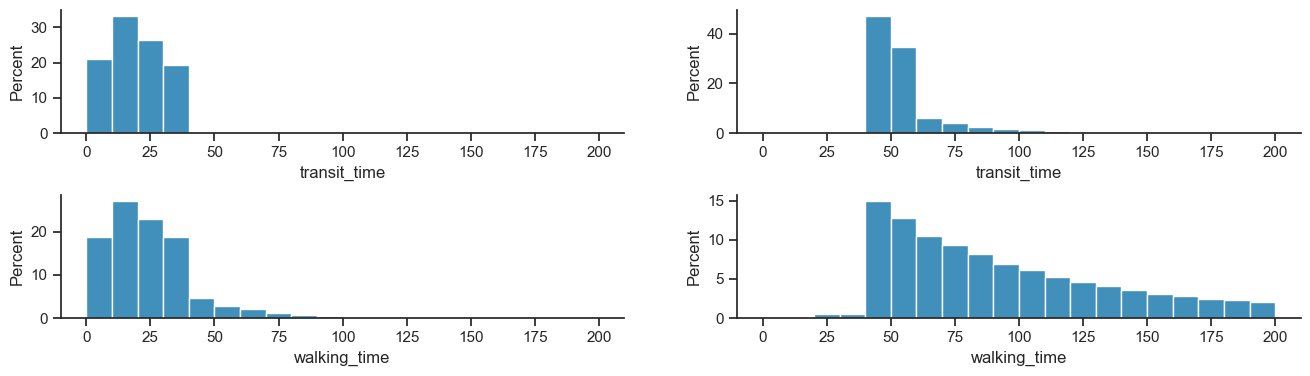

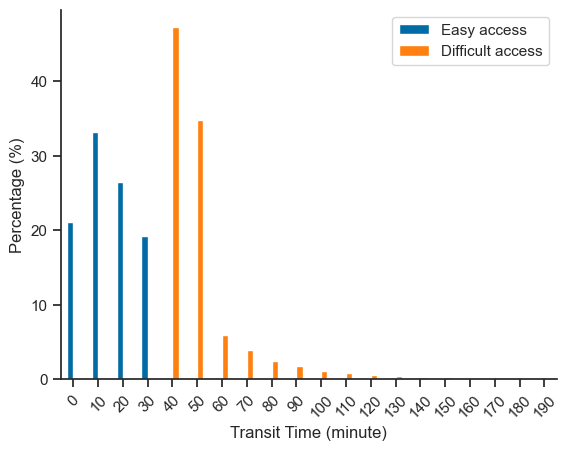

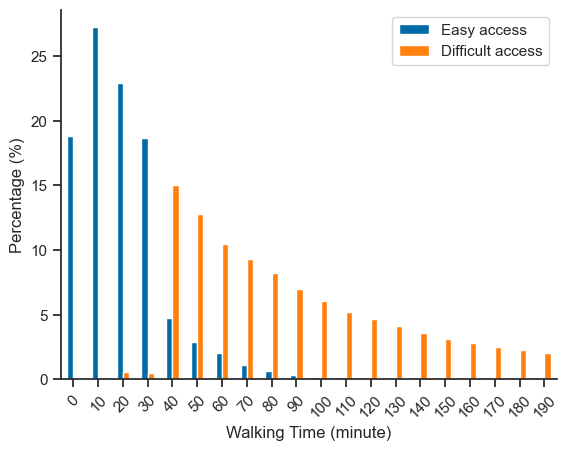

In [37]:
# Public Transit & Walking

fig, axes = plt.subplots(2, 2, figsize=(16,4))
fig.subplots_adjust(hspace = 0.5)

e_t = sns.histplot(ax=axes[0, 0], data=easy_access.transit_time, stat='percent', 
            bins=np.arange(0, 201, 10))
#axes[0,0].set(xlabel='Travel time by public transit (min)')

d_t = sns.histplot(ax=axes[0, 1], data=diff_access.transit_time, stat='percent', 
            bins=np.arange(0, 201, 10))
#axes[1,0].set(xlabel='Travel time by public transit (min)', ylabel='Density')

e_w = sns.histplot(ax=axes[1, 0], data=easy_access.walking_time, stat='percent', 
            bins=np.arange(0, 201, 10))
#axes[0,1].set(xlabel='Travel time by walking (min)', ylabel='Density')

d_w = sns.histplot(ax=axes[1, 1], data=diff_access.walking_time, stat='percent', 
            bins=np.arange(0, 201, 10))
#axes[1,1].set(xlabel='Travel time by walking (min)', ylabel='Density')


# Get heights of each bin
e_t_heights = [h.get_height() for h in e_t.patches]
d_t_heights = [h.get_height() for h in d_t.patches]

e_w_heights = [h.get_height() for h in e_w.patches]
d_w_heights = [h.get_height() for h in d_w.patches]

bins = np.arange(0, 200, 10)

pd.DataFrame({'Easy access':e_t_heights, 
              'Difficult access':d_t_heights}, index=bins).plot.bar(rot=0)
plt.xlabel('Transit Time (minute)')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)


pd.DataFrame({'Easy access':e_w_heights, 
              'Difficult access':d_w_heights}, index=bins).plot.bar(rot=0)
plt.xlabel('Walking Time (minute)')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)

# Supplementary Figure 3

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '[1-10]'),
  Text(1, 0, '[11-20]'),
  Text(2, 0, '[21-30]'),
  Text(3, 0, '[31-40]'),
  Text(4, 0, '[41-50]'),
  Text(5, 0, '[51-60]'),
  Text(6, 0, '[61-70]'),
  Text(7, 0, '[71-80]'),
  Text(8, 0, '[81-90]'),
  Text(9, 0, '[91-100]')])

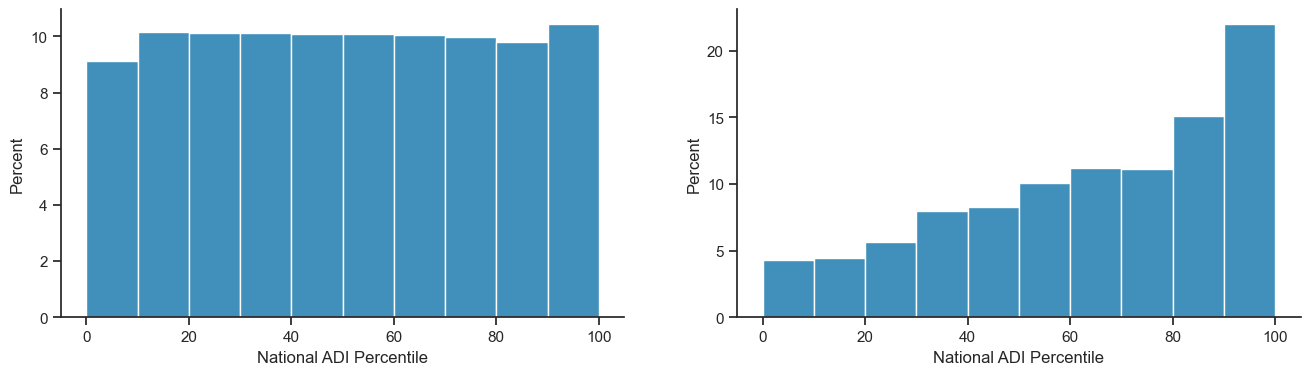

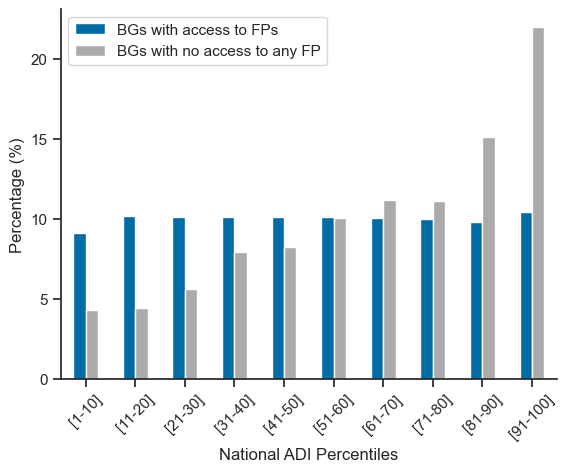

In [38]:
fig, axes = plt.subplots(1, 2,  figsize=(16, 4))
fig.subplots_adjust(hspace = 0.4)
#fig.tight_layout()

y = sns.histplot(ax=axes[0], data=pd.concat([easy_access, diff_access]).ADI_NATRANK, stat='percent', 
            bins=np.arange(0, 101, 10))
axes[0].set(xlabel='National ADI Percentile')

n = sns.histplot(ax=axes[1], data=no_access.ADI_NATRANK, stat='percent', 
            bins=np.arange(0, 101, 10))
axes[1].set(xlabel='National ADI Percentile')


# Get heights of each bin
y_heights = [h.get_height() for h in y.patches]
n_heights = [h.get_height() for h in n.patches]

pd.DataFrame({'BGs with access to FPs':y_heights, 
              'BGs with no access to any FP': n_heights}, index=['[1-10]', '[11-20]', '[21-30]', '[31-40]', '[41-50]', '[51-60]', '[61-70]', '[71-80]', '[81-90]', '[91-100]']).plot.bar(rot=0, color=['#006BA4', '#ABABAB'])
plt.xlabel('National ADI Percentiles')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)



# Supplementary Figure 4

`state_no_pantry` is the state-level percentage of BGs that do not have access (e.g., "no access") to any FPs within 25 miles. This dataset is created to be used for plotting in Tableau.

In [59]:
state_no_pantry = pd.DataFrame((no_access.bg_state.value_counts() * 100)/(bg_cont.bg_state.value_counts()))
state_no_pantry.reset_index(inplace=True)

state_no_pantry = state_no_pantry.rename(columns={'bg_state':'state', 'count':'perc_no_pantry'})

State-level % of "no access" BGs by descending order

In [62]:
state_no_pantry.sort_values(by=['perc_no_pantry'], ascending=False).round(2)

,state,perc_no_pantry
0,AK,21.63
50,WY,16.63
41,SD,12.82
32,NM,9.05
26,MT,8.67
11,HI,7.76
7,DC,6.83
33,NV,5.35
34,NY,4.85
22,MI,4.76


In [40]:
#state_no_pantry.to_csv('../data/state_no_pantry.csv', index=False)

# Supplementary Figure 5

`state_median_access` is created for plotting the median travel time that takes the least amount of time (between transit or walking) when visiting the nearest FPs, shown at the U.S. state level. Note that this data will be used in Tableau. 

In [47]:
state_median_access = bg_access.groupby('bg_state')['access'].median().reset_index()

The top five states with the highest median travel time

In [49]:
state_median_access.sort_values(by='access', ascending=False).head(5)

,bg_state,access
25,MS,101.370
49,WV,98.250
17,KY,78.385
1,AL,67.100
21,ME,63.700


The top five states with the lowest median travel time

In [50]:
state_median_access.sort_values(by='access', ascending=False).tail(5)

,bg_state,access
31,NJ,22.800
19,MA,21.850
39,RI,18.500
34,NY,16.820
7,DC,12.895


In [1]:
#state_median_access.to_csv('../data/state_median_access.csv', index=False)